In [2]:
# from pycaret.time_series import *
# from supervised.automl import AutoML

import pandas as pd
import numpy as np
import category_encoders as ce
import copy
import polars as pl

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
import plotly.express as px
%matplotlib inline
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치
# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor 
from sklearn.ensemble import StackingClassifier, StackingRegressor
# from sklearn.base import ClassifierMixin

# CatBoost
from catboost import CatBoostRegressor

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import holidays

# from bayes_opt import BayesianOptimization
# from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nflx = pd.read_csv('NFLX.csv')
nflx.head()

Date        Open        High         Low       Close   Adj Close  \
0  2019-01-28  334.700012  336.299988  328.880005  335.660004  335.660004   
1  2019-01-29  335.869995  338.220001  328.149994  328.899994  328.899994   
2  2019-01-30  332.750000  341.779999  330.799988  340.660004  340.660004   
3  2019-01-31  339.679993  345.989990  338.089996  339.500000  339.500000   
4  2019-02-01  337.179993  346.839996  336.500000  339.850006  339.850006   

    Volume  
0  8652100  
1  7655200  
2  9234500  
3  8535500  
4  9827800

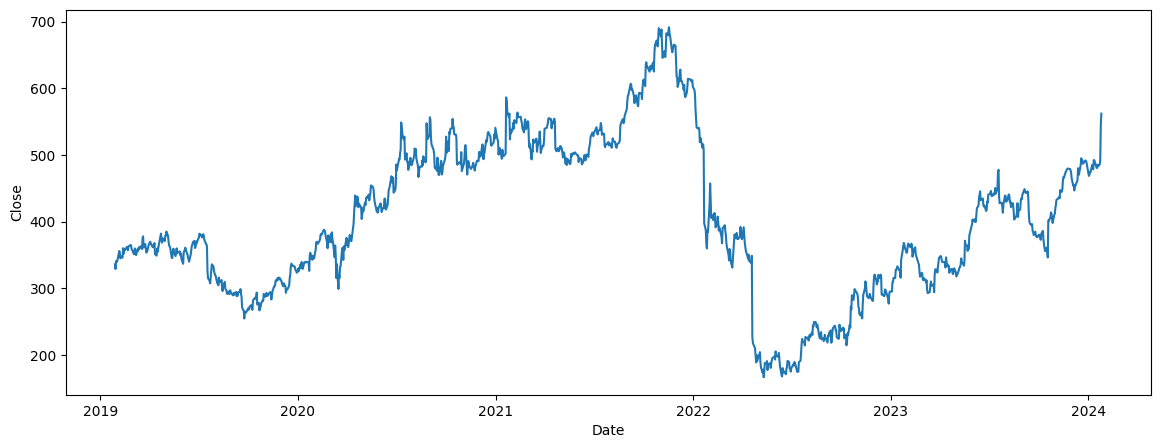

In [50]:
nflx['Date'] = pd.to_datetime(nflx['Date'])

plt.figure(figsize = (14,5))
plt.plot('Date', 'Close', data = nflx)
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

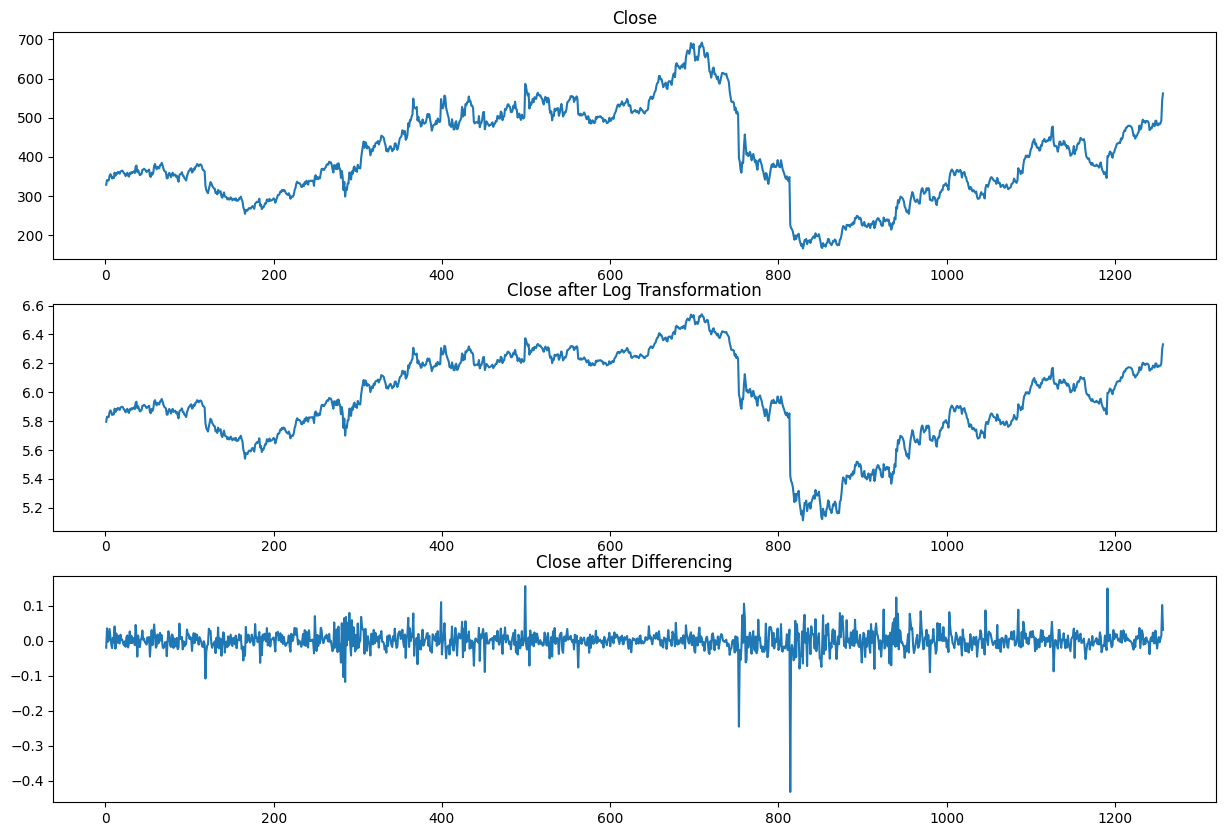

In [51]:
nflx['Close-log'] = np.log(nflx['Close'])
nflx['Close-station'] = nflx['Close-log'].diff(1)
nflx = nflx.dropna()
fig,ax = plt.subplots(3, figsize=(15,10))
ax[0].plot(nflx['Close'])
ax[0].set_title('Close')
ax[1].plot(nflx['Close-log'])
ax[1].set_title('Close after Log Transformation')
ax[2].plot(nflx['Close-station'])
ax[2].set_title('Close after Differencing')
plt.show()

In [52]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %d' % result[2])
    print('num of observations: %d' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))
    if result[1] <= 0.05:
        print("Evidence against the null hypothesis, the time series has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root indicating it is non-stationary ")

print("정상성 확인")
adf_test(nflx['Close-station'])  # Assuming 'Close' is the column with closing prices


정상성 확인
ADF Statistics: -24.125630
p-value: 0.000000
num of lags: 1
num of observations: 1255
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Evidence against the null hypothesis, the time series has no unit root and is stationary


In [53]:
# 50일 이동 평균
nflx['50_MA'] = nflx['Close-station'].rolling(window=50).mean()

# 100일 이동 평균
nflx['100_MA'] = nflx['Close-station'].rolling(window=100).mean()


In [54]:
# 1일 변화율
nflx['Momentum'] = nflx['Close-station'].pct_change().multiply(100)


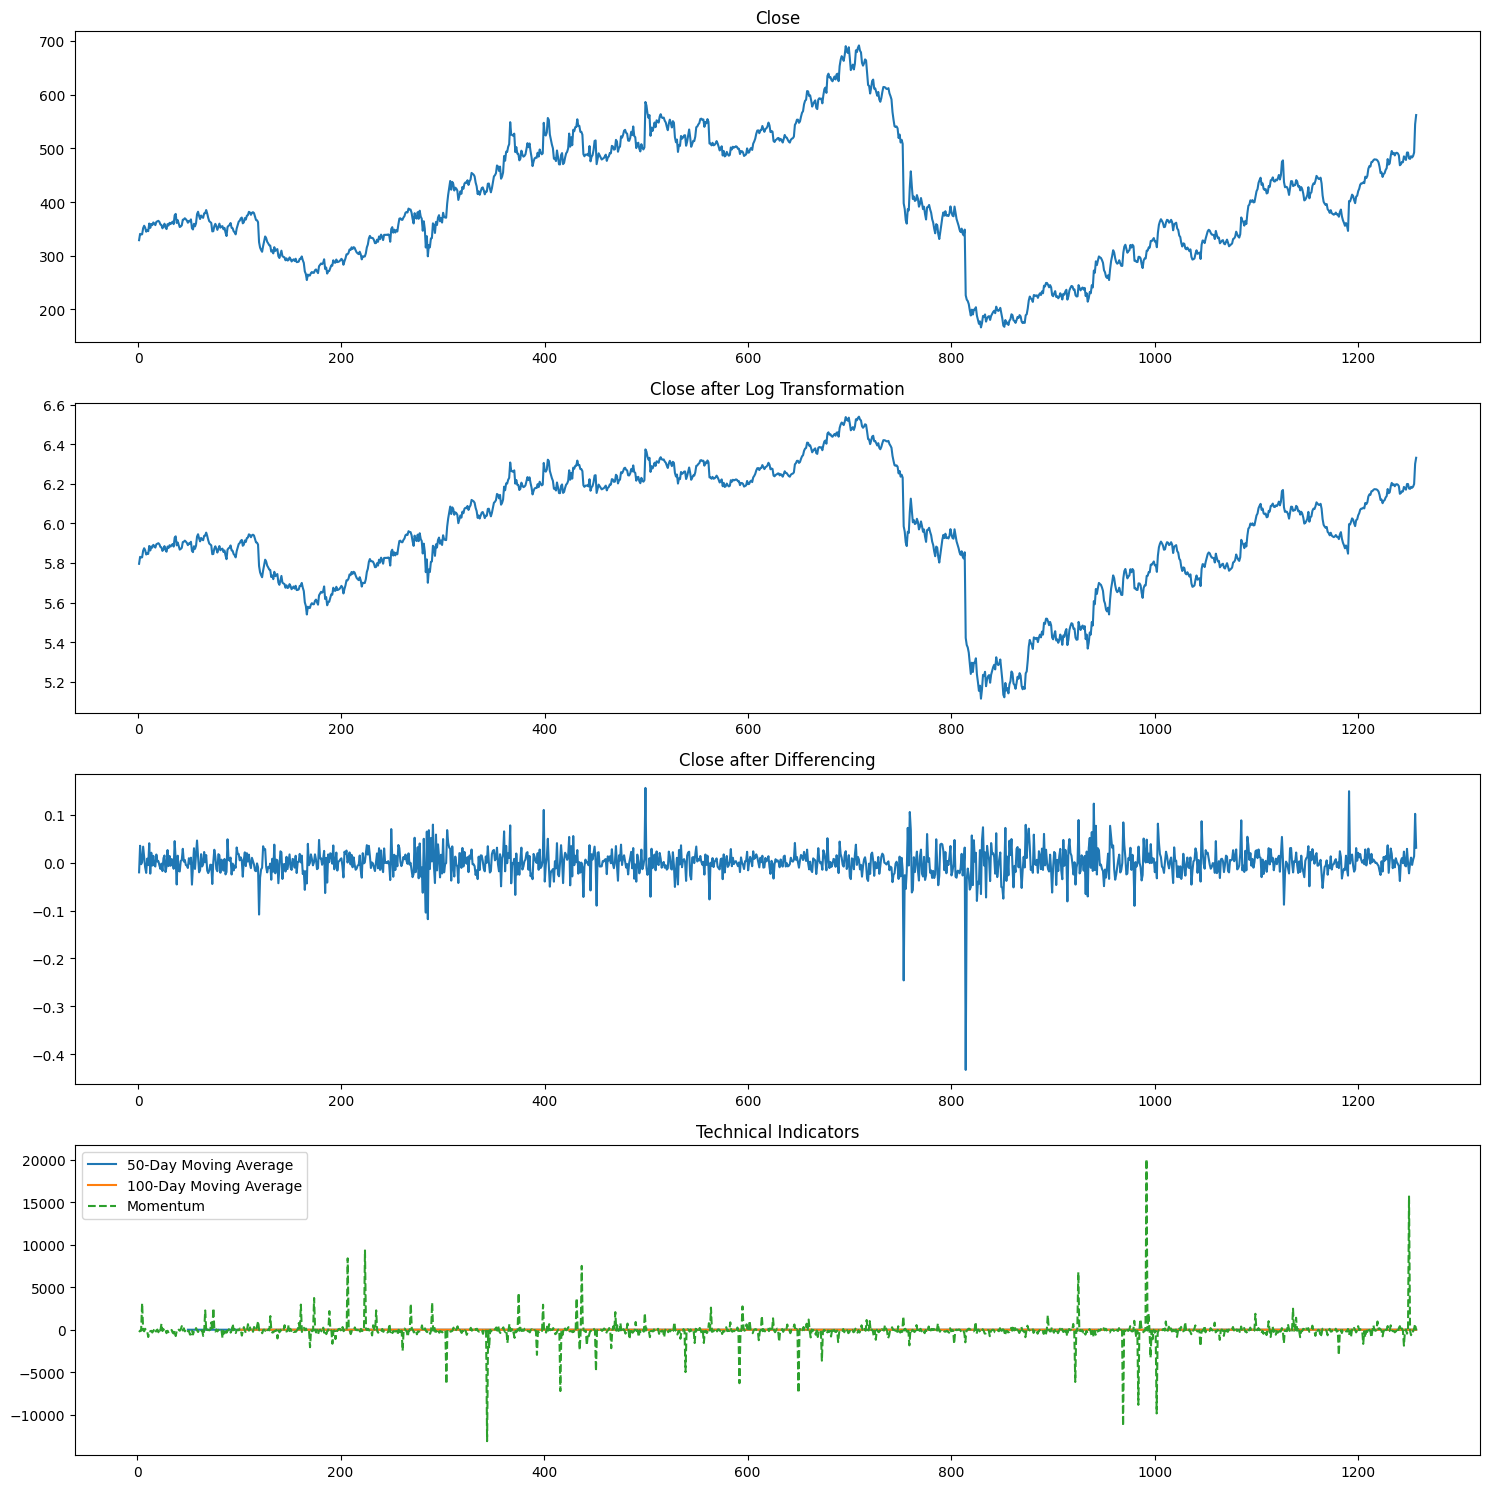

In [55]:
# 기술적 지표들을 그래프로 표현
fig, ax = plt.subplots(4, figsize=(15, 15))

# 원본 시계열 데이터
ax[0].plot(nflx['Close'])
ax[0].set_title('Close')

# 로그 변환 데이터
ax[1].plot(nflx['Close-log'])
ax[1].set_title('Close after Log Transformation')

# 차분 데이터
ax[2].plot(nflx['Close-station'])
ax[2].set_title('Close after Differencing')

# 이동 평균과 모멘텀 추가
ax[3].plot(nflx['50_MA'], label='50-Day Moving Average')
ax[3].plot(nflx['100_MA'], label='100-Day Moving Average')
ax[3].plot(nflx['Momentum'], label='Momentum', linestyle='--')
ax[3].legend()
ax[3].set_title('Technical Indicators')

plt.tight_layout()
plt.show()


In [56]:
nflx

Date        Open        High         Low       Close   Adj Close  \
1    2019-01-29  335.869995  338.220001  328.149994  328.899994  328.899994   
2    2019-01-30  332.750000  341.779999  330.799988  340.660004  340.660004   
3    2019-01-31  339.679993  345.989990  338.089996  339.500000  339.500000   
4    2019-02-01  337.179993  346.839996  336.500000  339.850006  339.850006   
5    2019-02-04  342.600006  352.000000  341.299988  351.339996  351.339996   
...         ...         ...         ...         ...         ...         ...   
1253 2024-01-19  484.980011  485.670013  476.059998  482.950012  482.950012   
1254 2024-01-22  487.549988  489.799988  479.899994  485.709991  485.709991   
1255 2024-01-23  492.000000  498.959991  481.399994  492.190002  492.190002   
1256 2024-01-24  537.750000  562.500000  537.070007  544.869995  544.869995   
1257 2024-01-25  551.950012  563.460022  548.460022  562.000000  562.000000   

        Volume  Close-log  Close-station     50_MA    100_MA     Momentum  
1      7655200   5.795754      -0.020345       NaN       NaN          NaN  
2      9234500   5.830885       0.035131       NaN       NaN  -272.677095  
3      8535500   5.827474      -0.003411       NaN       NaN  -109.709256  
4      9827800   5.828504       0.001030       NaN       NaN  -130.208776  
5      9051400   5.861754       0.033250       NaN       NaN  3126.861075  
...        ...        ...            ...       ...       ...          ...  
1253   5665600   6.179913      -0.004875  0.002103  0.001492  -147.260616  
1254   5212300   6.185612       0.005699  0.002223  0.001500  -216.900749  
1255  15506000   6.198865       0.013253  0.002395  0.001351   132.569132  
1256  26432800   6.300547       0.101682  0.004497  0.002260   667.234522  
1257   9425100   6.331502       0.030955  0.004568  0.002592   -69.557539  

[1257 rows x 12 columns]

In [57]:
nflx.drop(['Open', 'High', 'Low', 'Adj Close'], axis = 1, inplace = True)
nflx

Date       Close    Volume  Close-log  Close-station     50_MA  \
1    2019-01-29  328.899994   7655200   5.795754      -0.020345       NaN   
2    2019-01-30  340.660004   9234500   5.830885       0.035131       NaN   
3    2019-01-31  339.500000   8535500   5.827474      -0.003411       NaN   
4    2019-02-01  339.850006   9827800   5.828504       0.001030       NaN   
5    2019-02-04  351.339996   9051400   5.861754       0.033250       NaN   
...         ...         ...       ...        ...            ...       ...   
1253 2024-01-19  482.950012   5665600   6.179913      -0.004875  0.002103   
1254 2024-01-22  485.709991   5212300   6.185612       0.005699  0.002223   
1255 2024-01-23  492.190002  15506000   6.198865       0.013253  0.002395   
1256 2024-01-24  544.869995  26432800   6.300547       0.101682  0.004497   
1257 2024-01-25  562.000000   9425100   6.331502       0.030955  0.004568   

        100_MA     Momentum  
1          NaN          NaN  
2          NaN  -272.677095  
3          NaN  -109.709256  
4          NaN  -130.208776  
5          NaN  3126.861075  
...        ...          ...  
1253  0.001492  -147.260616  
1254  0.001500  -216.900749  
1255  0.001351   132.569132  
1256  0.002260   667.234522  
1257  0.002592   -69.557539  

[1257 rows x 8 columns]

In [58]:
nflx_stationed = nflx

In [59]:
nflx_stationed

Date       Close    Volume  Close-log  Close-station     50_MA  \
1    2019-01-29  328.899994   7655200   5.795754      -0.020345       NaN   
2    2019-01-30  340.660004   9234500   5.830885       0.035131       NaN   
3    2019-01-31  339.500000   8535500   5.827474      -0.003411       NaN   
4    2019-02-01  339.850006   9827800   5.828504       0.001030       NaN   
5    2019-02-04  351.339996   9051400   5.861754       0.033250       NaN   
...         ...         ...       ...        ...            ...       ...   
1253 2024-01-19  482.950012   5665600   6.179913      -0.004875  0.002103   
1254 2024-01-22  485.709991   5212300   6.185612       0.005699  0.002223   
1255 2024-01-23  492.190002  15506000   6.198865       0.013253  0.002395   
1256 2024-01-24  544.869995  26432800   6.300547       0.101682  0.004497   
1257 2024-01-25  562.000000   9425100   6.331502       0.030955  0.004568   

        100_MA     Momentum  
1          NaN          NaN  
2          NaN  -272.677095  
3          NaN  -109.709256  
4          NaN  -130.208776  
5          NaN  3126.861075  
...        ...          ...  
1253  0.001492  -147.260616  
1254  0.001500  -216.900749  
1255  0.001351   132.569132  
1256  0.002260   667.234522  
1257  0.002592   -69.557539  

[1257 rows x 8 columns]

In [60]:
nflx_stationed.isnull().sum()


Date              0
Close             0
Volume            0
Close-log         0
Close-station     0
50_MA            49
100_MA           99
Momentum          1
dtype: int64

In [61]:
mean_50ma = nflx_stationed["50_MA"].mean()
mean_100ma = nflx_stationed["100_MA"].mean()
momentum_mean = nflx_stationed['Momentum'].mean()


In [62]:
# 위에서 계산한 평균값을 사용하여 결측치를 채웁니다.
# 이전에 잘못된 할당을 했기 때문에, 다시 올바르게 각 열에 평균값을 할당합니다.

nflx['50_MA'] = nflx['50_MA'].fillna(mean_50ma)
nflx['100_MA'] = nflx['100_MA'].fillna(mean_100ma)
nflx['Momentum'] = nflx['Momentum'].fillna(momentum_mean)

# 결측치가 채워진 데이터프레임을 확인합니다.
nflx.isnull().sum()


Date             0
Close            0
Volume           0
Close-log        0
Close-station    0
50_MA            0
100_MA           0
Momentum         0
dtype: int64

In [65]:
nflx_stationed

Date       Close    Volume  Close-log  Close-station     50_MA  \
1    2019-01-29  328.899994   7655200   5.795754      -0.020345  0.000242   
2    2019-01-30  340.660004   9234500   5.830885       0.035131  0.000242   
3    2019-01-31  339.500000   8535500   5.827474      -0.003411  0.000242   
4    2019-02-01  339.850006   9827800   5.828504       0.001030  0.000242   
5    2019-02-04  351.339996   9051400   5.861754       0.033250  0.000242   
...         ...         ...       ...        ...            ...       ...   
1253 2024-01-19  482.950012   5665600   6.179913      -0.004875  0.002103   
1254 2024-01-22  485.709991   5212300   6.185612       0.005699  0.002223   
1255 2024-01-23  492.190002  15506000   6.198865       0.013253  0.002395   
1256 2024-01-24  544.869995  26432800   6.300547       0.101682  0.004497   
1257 2024-01-25  562.000000   9425100   6.331502       0.030955  0.004568   

        100_MA     Momentum  
1     0.000173   -91.976810  
2     0.000173  -272.677095  
3     0.000173  -109.709256  
4     0.000173  -130.208776  
5     0.000173  3126.861075  
...        ...          ...  
1253  0.001492  -147.260616  
1254  0.001500  -216.900749  
1255  0.001351   132.569132  
1256  0.002260   667.234522  
1257  0.002592   -69.557539  

[1257 rows x 8 columns]

In [70]:
# RSI 계산을 위한 함수 정의
def calculate_rsi(data, window=14):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()

    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the Exponential Moving Average (EMA) of the ups and downs
    roll_up = up.rolling(window).mean()
    roll_down = down.abs().rolling(window).mean()

    # Calculate the RSI based on the formula
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))

    return RSI

# 'Close' 컬럼에 대한 RSI 계산
nflx_stationed['RSI'] = calculate_rsi(nflx_stationed['Close'], window=14)

# 결측치 처리
nflx_stationed['RSI'] = nflx_stationed['RSI'].fillna(method='bfill') # backfill to handle initial NA values

# RSI 계산 후의 DataFrame을 확인합니다.
nflx_stationed.head(100)


Date       Close   Volume  Close-log  Close-station     50_MA  \
1   2019-01-29  328.899994  7655200   5.795754      -0.020345  0.000242   
2   2019-01-30  340.660004  9234500   5.830885       0.035131  0.000242   
3   2019-01-31  339.500000  8535500   5.827474      -0.003411  0.000242   
4   2019-02-01  339.850006  9827800   5.828504       0.001030  0.000242   
5   2019-02-04  351.339996  9051400   5.861754       0.033250  0.000242   
..         ...         ...      ...        ...            ...       ...   
96  2019-06-14  339.730011  5019000   5.828151      -0.010832 -0.001694   
97  2019-06-17  350.619995  5358200   5.859703       0.031552 -0.000961   
98  2019-06-18  357.119995  5428500   5.878072       0.018369 -0.000463   
99  2019-06-19  363.519989  5667200   5.895834       0.017762  0.000116   
100 2019-06-20  365.209991  5899500   5.900473       0.004638  0.000027   

       100_MA     Momentum        RSI  
1    0.000173   -91.976810  70.129228  
2    0.000173  -272.677095  70.129228  
3    0.000173  -109.709256  70.129228  
4    0.000173  -130.208776  70.129228  
5    0.000173  3126.861075  70.129228  
..        ...          ...        ...  
96   0.000173    75.191218  39.498558  
97   0.000173  -391.281237  47.225690  
98   0.000173   -41.781918  54.916303  
99   0.000173    -3.301264  56.914320  
100  0.000844   -73.887483  64.146566  

[100 rows x 9 columns]

In [72]:
# nflx DataFrame을 csv 파일로 저장합니다.
# 파일 이름을 'nflx_stationed.csv'로 지정합니다.
nflx.to_csv('nflx_stationed.csv', index=False)

# 파일 저장 경로를 반환합니다.
'nflx_stationed.csv'


'nflx_stationed.csv'

# Combine news & stock

In [10]:
import pandas as pd

class PrepareData():
    def __init__(self,stock_fp,news_fp):
        self.stock_filepath = stock_fp
        self.news_filepath = news_fp
        self.topic_classes = ['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined',
       'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall',
       'product', 'recession', 'tanalysis'] # undefined의 class가 5
        
    def load_data(self):
        stock = pd.read_csv(self.stock_filepath,index_col=0)
        news = pd.read_csv(self.news_filepath,index_col=0)
        ### parse date manually
        stock['Date'] = pd.to_datetime(stock['Date'])
        news['date'] = pd.to_datetime(news['date'])
        return stock, news
    
    def merging(self, stock, news):
        ### fill na value of PINS column
#         stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])
        
        ### drop 'news_id' column
#         news = news.drop(columns=['news_id'])
        
        ### add date range from 18.01.02 to 18.12.31
        temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                                0,0,0,0, # 4
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 16
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 28
                                0,0,0,0, 
                                0,0,0,0, # 36
                                0 # 37
                            ])))
        stock_inc = pd.concat([temp_range,stock],axis=0)

        ### merge stock_inc and news 
        # left = stock_inc
        # on = date
        # how = left
        # rename 'date' to 'Date' of news df
        news = news.rename(columns={'date':'Date'})
        merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')

        ### Cut before 2018-02-13
        merged = merged[42:].reset_index(drop=True)
        
        # fill na with latest non-null values
        columns_to_fill = ['source_name', 'topics', 'rank_score', 
                        'sentiment_Negative','sentiment_Neutral', 
                        'sentiment_Positive', 'type_Article', 'type_Video']
        merged_fillna = merged.copy()
        for column in columns_to_fill:
            merged_fillna[column].fillna(method='ffill',inplace=True)

        ### add moving average to sentiments
        ma_nums = [5,60,120]
        def mode_window(window):
            return window.mode().iloc[0] if not len(window.mode())==0 else None
        for num in ma_nums:
            merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).mean()
        ### add moving mode to sentiments
        for num in ma_nums:
            merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).apply(mode_window)
        ### adding moving mode to topics
        for num in ma_nums:
            merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
            window=num).apply(mode_window)

        ### drop before 2019-01-02
        total_df = merged_fillna.iloc[322:]
        total_df = total_df.reset_index(drop=True)

        ### drop unnecessaray columns
        drop_cols = ['source_name','topics','rank_score',
                    'sentiment_Negative','sentiment_Neutral',
                    'sentiment_Positive','type_Article','type_Video']
        total_df = total_df.drop(columns=drop_cols)

        return total_df

In [5]:
stock = pd.read_csv('../../data/stock_price/netflix_60.csv',index_col=0,
                    parse_dates=True)
news = pd.read_csv('../../data/scraping/news_processed_filtered_2.csv',
                   parse_dates=True)
### fill null PINS price with lastest price
stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])
news = news.drop(columns=['news_id'])
stock['Date'] = pd.to_datetime(stock['Date'])
news['date'] = pd.to_datetime(news['date'])
display(stock.head(2))
display(news.head(2))

Date    Open   Close    High     Low    Volume    1d_ROC     5d_ROC  \
0 2019-01-02  259.28  267.66  269.75  256.58  11642148  0.000000  14.443304   
1 2019-01-03  270.20  271.20  275.79  264.43  14954204  1.322573   6.910553   

       5MA       120MA    bol_high     bol_low           ADI        OBV  \
0  260.128  325.000667  286.872017  242.471983  1.326076e+08  114631377   
1  263.634  323.962333  286.339561  242.591439  1.354773e+08  129585581   

        CMF            FI         EOM           VPT         NVI        ATR  \
0 -0.061244  1.080230e+07 -213.237712  5.182140e+06  1127.28888  15.042858   
1 -0.064746  1.682167e+07  527.578733  5.379921e+06  1127.28888  14.981477   

         UI      MACD        ADX       -VI       +VI      TRIX         MI  \
0  8.947993 -7.398435  25.068628  1.070193  0.878804 -0.468704  24.924196   
1  8.846980 -6.060607  23.675017  1.054425  0.890686 -0.441866  24.927295   

         CCI     DPO        KST        STC        RSI      SRSI         UO  \
0 -72.480377  2.1680 -88.281564  44.762606  45.523889  0.384404  48.377492   
1 -56.022123 -1.6655 -86.593692  64.779342  45.949547  0.424055  49.951722   

         MFI    SPOT   PINS      FB  
0  44.377291  135.68  24.99  113.74  
1  46.086376  131.74  24.99  109.02

source_name  topics  rank_score       date  sentiment_Negative  \
0            7       7        6.56 2018-02-13                 0.0   
1            7       7        6.56 2018-03-29                 0.0   

   sentiment_Neutral  sentiment_Positive  type_Article  type_Video  
0                1.0                 0.0           0.0         1.0  
1                1.0                 0.0           0.0         1.0

In [6]:
news['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 939 entries, 0 to 938
Series name: date
Non-Null Count  Dtype         
--------------  -----         
939 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 7.5 KB


In [75]:
### add date range from 18.01.02 to 18.12.31
temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                        0,0,0,0, # 4
                        0,0,0,0,
                        0,0,0,0,
                        0,0,0,0, # 16
                        0,0,0,0,
                        0,0,0,0,
                        0,0,0,0, # 28
                        0,0,0,0, 
                        0,0,0,0, # 36
                        0 # 37
                       ])))
stock_inc = pd.concat([temp_range,stock],axis=0)

### merge stock_inc and news 
# left = stock_inc
# on = date
# how = left
# rename 'date' to 'Date' of news df
news = news.rename(columns={'date':'Date'})
merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')
merged.head(10)

Date    Open   Close    High     Low     Volume     1d_ROC  \
0    2018-01-02    0.00    0.00    0.00    0.00          0   0.000000   
1    2018-01-03    0.00    0.00    0.00    0.00          0   0.000000   
2    2018-01-04    0.00    0.00    0.00    0.00          0   0.000000   
3    2018-01-05    0.00    0.00    0.00    0.00          0   0.000000   
4    2018-01-06    0.00    0.00    0.00    0.00          0   0.000000   
5    2018-01-07    0.00    0.00    0.00    0.00          0   0.000000   
6    2018-01-08    0.00    0.00    0.00    0.00          0   0.000000   
7    2018-01-09    0.00    0.00    0.00    0.00          0   0.000000   
8    2018-01-10    0.00    0.00    0.00    0.00          0   0.000000   
9    2018-01-11    0.00    0.00    0.00    0.00          0   0.000000   
10   2018-01-12    0.00    0.00    0.00    0.00          0   0.000000   
11   2018-01-13    0.00    0.00    0.00    0.00          0   0.000000   
12   2018-01-14    0.00    0.00    0.00    0.00          0   0.000000   
13   2018-01-15    0.00    0.00    0.00    0.00          0   0.000000   
14   2018-01-16    0.00    0.00    0.00    0.00          0   0.000000   
15   2018-01-17    0.00    0.00    0.00    0.00          0   0.000000   
16   2018-01-18    0.00    0.00    0.00    0.00          0   0.000000   
17   2018-01-19    0.00    0.00    0.00    0.00          0   0.000000   
18   2018-01-20    0.00    0.00    0.00    0.00          0   0.000000   
19   2018-01-21    0.00    0.00    0.00    0.00          0   0.000000   
20   2018-01-22    0.00    0.00    0.00    0.00          0   0.000000   
21   2018-01-23    0.00    0.00    0.00    0.00          0   0.000000   
22   2018-01-24    0.00    0.00    0.00    0.00          0   0.000000   
23   2018-01-25    0.00    0.00    0.00    0.00          0   0.000000   
24   2018-01-26    0.00    0.00    0.00    0.00          0   0.000000   
25   2018-01-27    0.00    0.00    0.00    0.00          0   0.000000   
26   2018-01-28    0.00    0.00    0.00    0.00          0   0.000000   
27   2018-01-29    0.00    0.00    0.00    0.00          0   0.000000   
28   2018-01-30    0.00    0.00    0.00    0.00          0   0.000000   
29   2018-01-31    0.00    0.00    0.00    0.00          0   0.000000   
30   2018-02-01    0.00    0.00    0.00    0.00          0   0.000000   
31   2018-02-02    0.00    0.00    0.00    0.00          0   0.000000   
32   2018-02-03    0.00    0.00    0.00    0.00          0   0.000000   
33   2018-02-04    0.00    0.00    0.00    0.00          0   0.000000   
34   2018-02-05    0.00    0.00    0.00    0.00          0   0.000000   
35   2018-02-06    0.00    0.00    0.00    0.00          0   0.000000   
36   2018-02-07    0.00    0.00    0.00    0.00          0   0.000000   
37   2018-02-08    0.00    0.00    0.00    0.00          0   0.000000   
38   2018-02-09    0.00    0.00    0.00    0.00          0   0.000000   
39   2018-02-10    0.00    0.00    0.00    0.00          0   0.000000   
40   2018-02-11    0.00    0.00    0.00    0.00          0   0.000000   
41   2018-02-12    0.00    0.00    0.00    0.00          0   0.000000   
42   2018-02-13    0.00    0.00    0.00    0.00          0   0.000000   
43   2018-02-14    0.00    0.00    0.00    0.00          0   0.000000   
44   2018-02-15    0.00    0.00    0.00    0.00          0   0.000000   
45   2018-02-16    0.00    0.00    0.00    0.00          0   0.000000   
46   2018-02-17    0.00    0.00    0.00    0.00          0   0.000000   
47   2018-02-18    0.00    0.00    0.00    0.00          0   0.000000   
48   2018-02-19    0.00    0.00    0.00    0.00          0   0.000000   
49   2018-02-20    0.00    0.00    0.00    0.00          0   0.000000   
50   2018-02-21    0.00    0.00    0.00    0.00          0   0.000000   
51   2018-02-22    0.00    0.00    0.00    0.00          0   0.000000   
52   2018-02-23    0.00    0.00    0.00    0.00          0   0.000000   
53   2018-02-24    0.00    0.00    0.00    0.00          0   0.000000

In [76]:
### Cut before 2018-02-13
merged_ = merged.copy()
merged_ = merged_[42:].reset_index(drop=True)
merged_.head(1)

Date  Open  Close  High  Low  Volume  1d_ROC  5d_ROC  5MA  120MA  \
0 2018-02-13   0.0    0.0   0.0  0.0       0     0.0     0.0  0.0    0.0   

   bol_high  bol_low  ADI  OBV  CMF   FI  EOM  VPT  NVI  ATR   UI  MACD  ADX  \
0       0.0      0.0  0.0    0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   

   -VI  +VI  TRIX   MI  CCI  DPO  KST  STC  RSI  SRSI   UO  MFI  SPOT  PINS  \
0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0   

    FB  source_name  topics  rank_score  sentiment_Negative  \
0  0.0          7.0     7.0        6.56                 0.0   

   sentiment_Neutral  sentiment_Positive  type_Article  type_Video  
0                1.0                 0.0           0.0         1.0

In [77]:
# fill na with latest non-null values
columns_to_fill = ['source_name', 'topics', 'rank_score', 
                   'sentiment_Negative','sentiment_Neutral', 
                   'sentiment_Positive', 'type_Article', 'type_Video']
merged_fillna = merged_.copy()
for column in columns_to_fill:
    merged_fillna[column].fillna(method='ffill',inplace=True)

In [78]:
### add moving average to sentiments
ma_nums = [5,60,120]
def mode_window(window):
    return window.mode().iloc[0] if not len(window.mode())==0 else None
for num in ma_nums:
    merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
    window=num).mean()
    merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
    window=num).mean()
    merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
    window=num).mean()
### add moving mode to sentiments
for num in ma_nums:
    merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
    window=num).apply(mode_window)
    merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
    window=num).apply(mode_window)
    merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
    window=num).apply(mode_window)
### adding moving mode to topics
for num in ma_nums:
    merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
    window=num).apply(mode_window)

In [79]:
### cut before 2019-01-02
total_df = merged_fillna.iloc[322:]
total_df = total_df.reset_index(drop=True)

### drop unnecessaray columns
drop_cols = ['source_name','topics','rank_score',
             'sentiment_Negative','sentiment_Neutral',
             'sentiment_Positive','type_Article','type_Video']
total_df = total_df.drop(columns=drop_cols)

In [80]:
total_df.head(5)

Date    Open   Close    High     Low    Volume    1d_ROC     5d_ROC  \
0 2019-01-02  259.28  267.66  269.75  256.58  11642148  0.000000  14.443304   
1 2019-01-03  270.20  271.20  275.79  264.43  14954204  1.322573   6.910553   
2 2019-01-04  281.88  297.57  297.80  278.54  19309374  9.723451  16.433854   
3 2019-01-07  302.10  315.34  316.80  301.65  18598132  5.971704  23.141206   
4 2019-01-08  319.98  320.27  320.59  308.01  15324452  1.563392  19.655533   

       5MA       120MA    bol_high     bol_low           ADI        OBV  \
0  260.128  325.000667  286.872017  242.471983  1.326076e+08  114631377   
1  263.634  323.962333  286.339561  242.591439  1.354773e+08  129585581   
2  272.034  323.104750  291.444515  239.710485  1.543255e+08  148894955   
3  283.886  322.570250  300.275444  234.125556  1.693391e+08  167493087   
4  294.408  322.113083  310.280492  229.633508  1.838839e+08  182817539   

        CMF            FI          EOM           VPT          NVI        ATR  \
0 -0.061244  1.080230e+07  -213.237712  5.182140e+06  1127.288880  15.042858   
1 -0.064746  1.682167e+07   527.578733  5.379921e+06  1127.288880  14.981477   
2 -0.046626  8.715975e+07  1801.382064  7.257458e+06  1127.288880  15.175119   
3 -0.009259  1.219210e+08  1715.135961  8.368084e+06  1194.607237  15.242701   
4  0.015975  1.152965e+08   416.611961  8.607665e+06  1213.283630  15.198322   

         UI      MACD        ADX       -VI       +VI      TRIX         MI  \
0  8.947993 -7.398435  25.068628  1.070193  0.878804 -0.468704  24.924196   
1  8.846980 -6.060607  23.675017  1.054425  0.890686 -0.441866  24.927295   
2  8.748754 -2.839794  23.280846  1.036458  0.890141 -0.390592  24.917587   
3  8.477965  1.133546  23.924840  1.019173  0.928652 -0.311443  24.915600   
4  8.091113  4.626921  24.695894  0.995371  0.943656 -0.212544  24.968010   

         CCI     DPO        KST        STC        RSI      SRSI         UO  \
0 -72.480377  2.1680 -88.281564  44.762606  45.523889  0.384404  48.377492   
1 -56.022123 -1.6655 -86.593692  64.779342  45.949547  0.424055  49.951722   
2   1.767185  5.3625 -75.831614  79.644575  48.970092  0.705424  53.480333   
3  59.409267 -0.4305 -56.832386  89.822288  50.852293  0.880754  56.283542   
4  74.434105 -9.3770 -28.087969  94.911144  51.358475  0.927906  59.329800   

         MFI    SPOT   PINS      FB  5MA_sent_Neg  5MA_sent_Neu  5MA_sent_Pos  \
0  44.377291  135.68  24.99  113.74           0.0           1.0           0.0   
1  46.086376  131.74  24.99  109.02           0.0           1.0           0.0   
2  46.642910  137.95  24.99  118.51           0.0           1.0           0.0   
3  48.992941  138.05  24.99  119.36           0.0           1.0           0.0   
4  51.038876  142.53  24.99  117.48           0.0           1.0           0.0   

   60MA_sent_Neg  60MA_sent_Neu  60MA_sent_Pos  120MA_sent_Neg  \
0            0.0            1.0            0.0             0.0   
1            0.0            1.0            0.0             0.0   
2            0.0            1.0            0.0             0.0   
3            0.0            1.0            0.0             0.0   
4            0.0            1.0            0.0             0.0   

   120MA_sent_Neu  120MA_sent_Pos  5MM_sent_Neg  5MM_sent_Neu  5MM_sent_Pos  \
0             1.0             0.0           0.0           1.0           0.0   
1             1.0             0.0           0.0           1.0           0.0   
2             1.0             0.0           0.0           1.0           0.0   
3             1.0             0.0           0.0           1.0           0.0   
4             1.0             0.0           0.0           1.0           0.0   

   60MM_sent_Neg  60MM_sent_Neu  60MM_sent_Pos  120MM_sent_Neg  \
0            0.0            1.0            0.0             0.0   
1            0.0            1.0            0.0             0.0   
2            0.0            1.0            0.0             0.0   
3            0.0            1.0            0.0

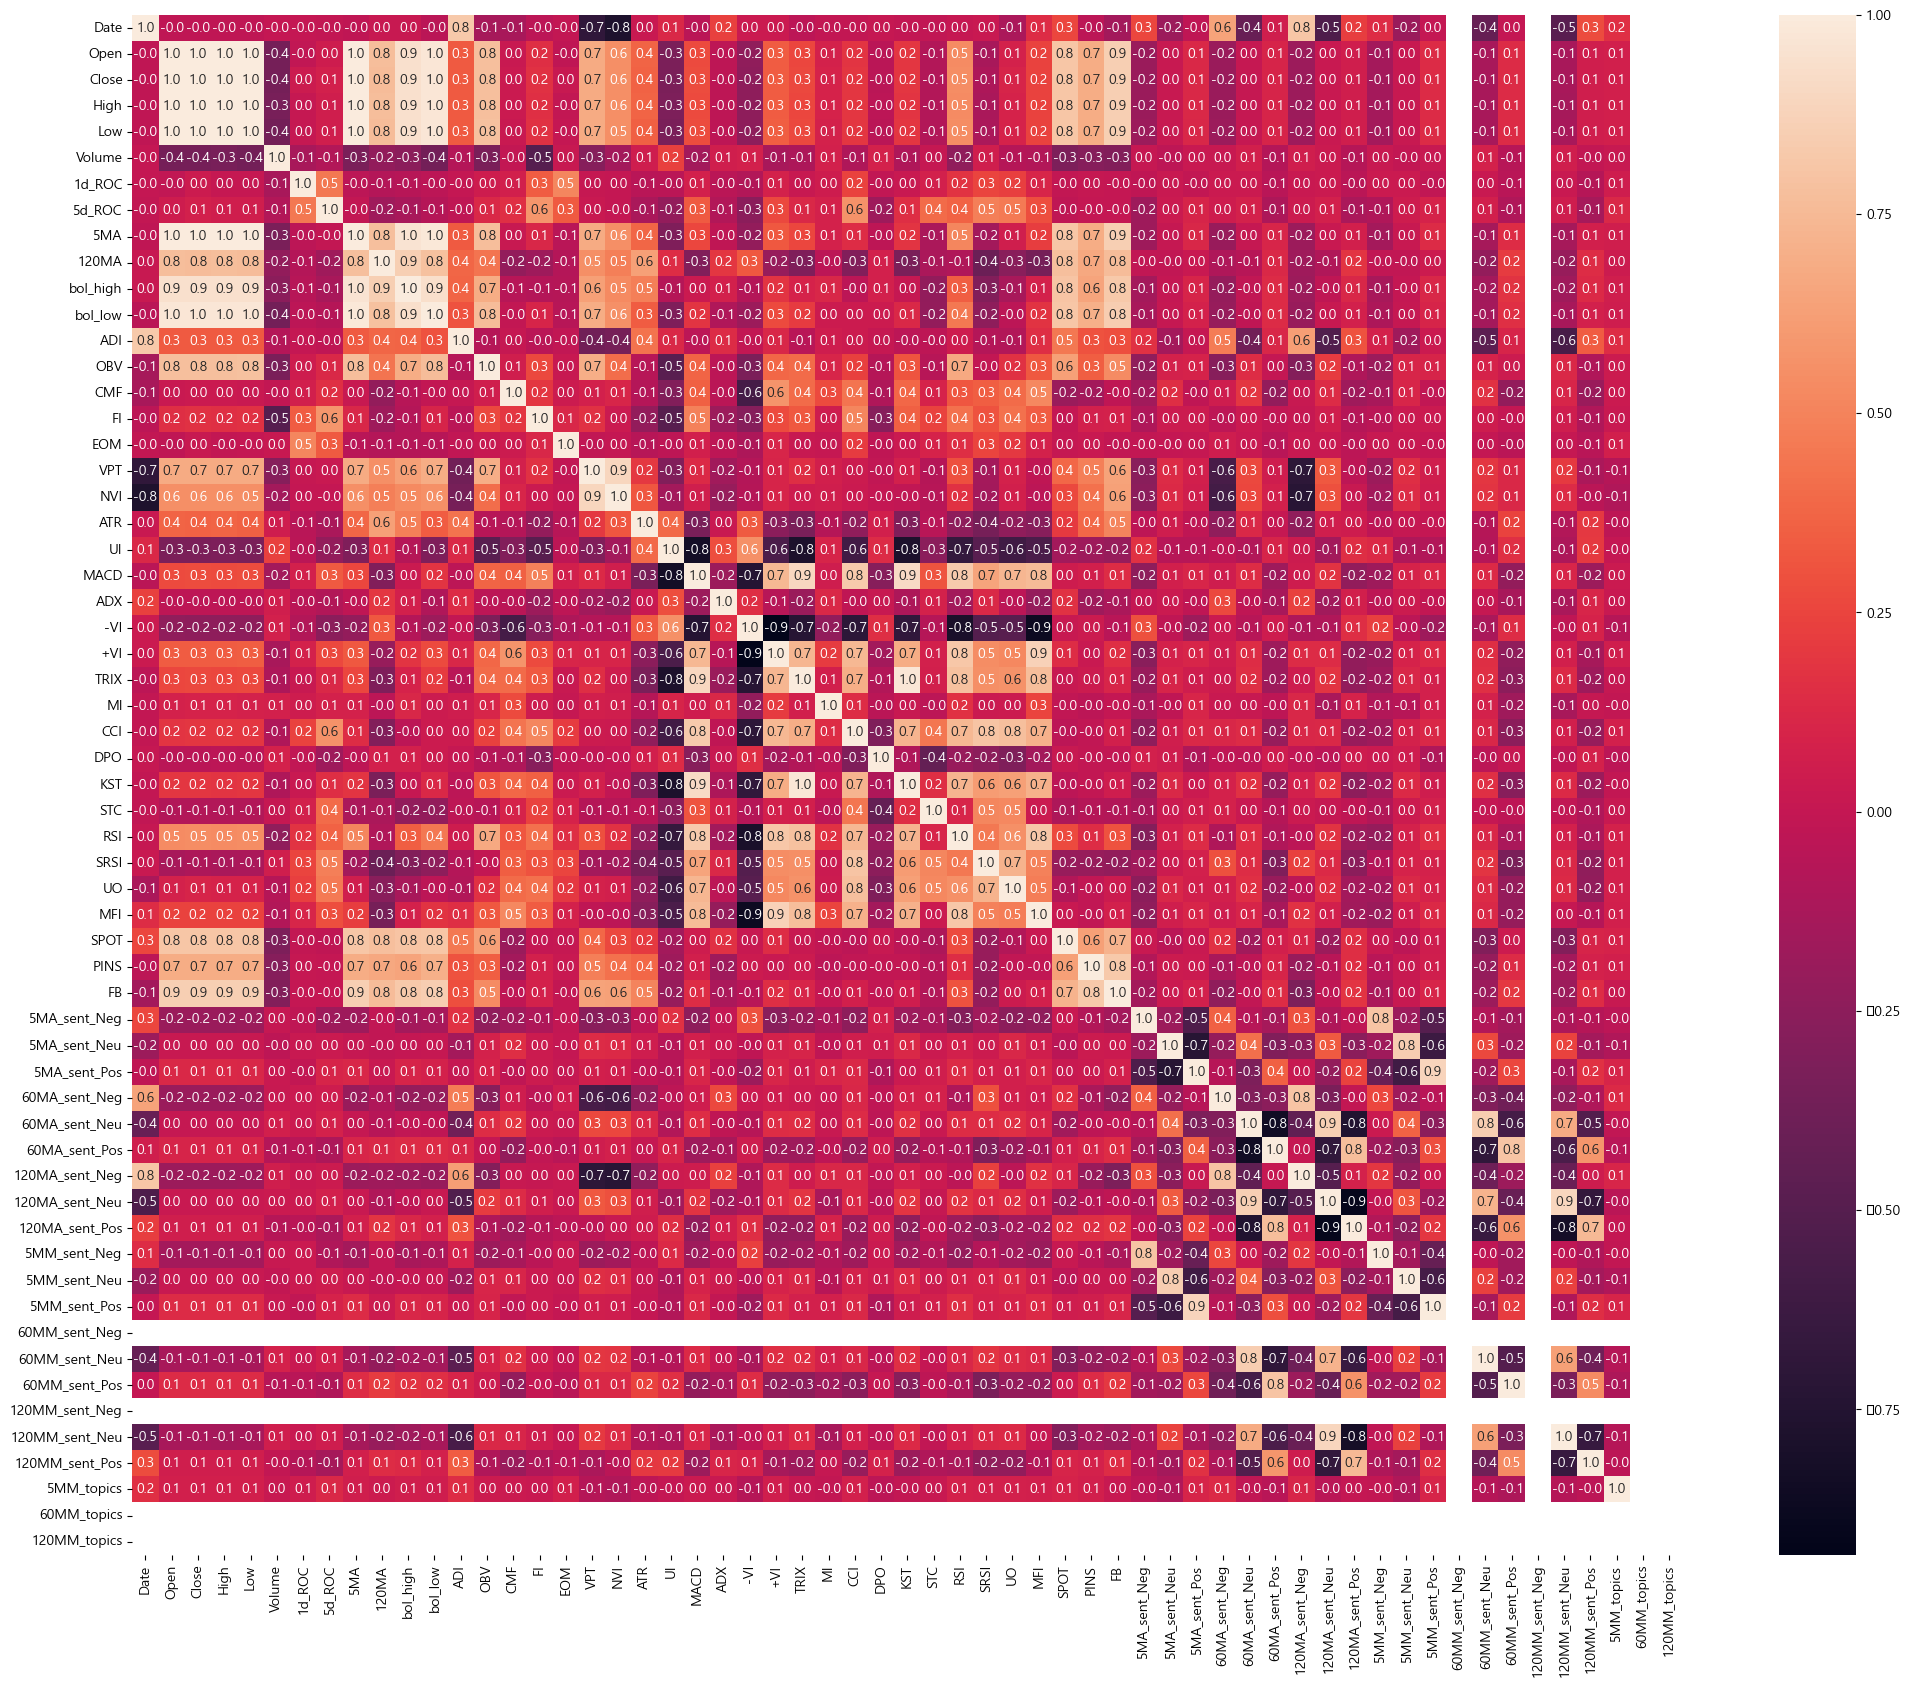

In [82]:
plt.figure(figsize=(25,20))
total_df_corr = total_df.corr()
sns.heatmap(total_df_corr, annot=True, fmt='.1f')
# plt.savefig('./hello.png',dpi=300)
plt.show()

In [84]:
total_df.shape

(1257, 59)

In [11]:
### Test the Class
stock_fp = '../../data/stock_price/netflix_60.csv'
news_fp = '../../data/scraping/news_processed_filtered_2.csv'
loader = PrepareData(stock_fp,news_fp)
stock_df, news_df=loader.load_data()
result = loader.merging(stock=stock_df, news=news_df)
print(result.shape)
print(loader.topic_classes)

(1257, 59)
['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined', 'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall', 'product', 'recession', 'tanalysis']
